# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Mads Rud Larsen (DTU)
#  Edited by: Amal Alghamdi (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Reconstruction of fast-ion distribution function in fusion plasmas

The first thing we will do is to import the CUQIpy software

In [7]:
import cuqi
from cuqi.distribution import UserDefinedDistribution

## Introduction and forward problem formulation
Here follows a short introduction to the physical and mathematical problem that we seek to solve.

In magnetically confined fusion plasmas the most energetic positively charged ions are dubbed fast ions, and a thorough understanding of their dynamics are vital in the pursuit of commercially viable fusion energy. Fast ions are born as fusion products, needed for sustaining the high temperature of the plasma, can drive instabilities deteriorating the plasma confinement, but can also suppress turbulence. Thus, they are both a blessing and a curse, but definitely inevitable.

The fast-ion dynamics are captured in the fast-ion distribution function $f$, which is generally six dimensional, three position coordinates and three velocity coordinates,
$$
    f=f(\mathbf{x},\mathbf{v}).
$$
Taking advantage of symmetries of the system, we can reduce the number of dimensions. The plasma is confined in a tokamak, which is a toroidally symmetric fusion device. In a cylindrical coordinate system, we can therefore ignore the toroidal angle and reduce the number of position coordinates to two $(R,z)$. Likewise we can discard one velocity coordinate, since the mangetic moment of the fast ions is an adiabatic invariant. The magnetic moment is related to the gyromotion of the ions around the magnetic field lines, which can therefore be ignored. The fast-ion distribution function can thus be expressed in 4D.

The problem is that the fast-ion distribution function cannot be measured directly. However, we can measure diagnostic signals $s$ depending on the fast-ion distribution function and invert the relation to reconstruct $f$. For interactions between a fast ion and a much less energetic target, the signal $s$ depends linearly on $f$ [1],
$$
    s(u_{1},u_{2},\varphi)=\int\int w(u_{1},u_{2},\varphi,\mathbf{x},\mathbf{v})f(\mathbf{x},\mathbf{v})\mathrm{d}\mathbf{x}\mathrm{d}\mathbf{v},
$$
where $\mathbf{x}=(R,z)$ and $\mathbf{v}=(v_{\parallel},v_{\perp})$ which denotes the velocities parallel and perpendicular to the magnetic field line, respectively. This is our forward problem. Discretising the forward problem, we have the matrix-vector product
$$
    \mathbf{s}=W\mathbf{f}
$$
where each row in $W$ is a weight function and $\mathbf{f}$ is the vectorised fast-ion distribution function.

Now we introduce strong prior information on the dynamics of fast ions. Over time fast ions born in the plasma will collide with the bulk of the plasma and slow down until reaching a steady state distribution, which we call a slowing-down distribution function. In this numerical experiment, we run a series of simulations initialising a number of fast ions in different sources placed strategiacally around the plasma volume, such that the resulting slowing-down distribution functions cover the entire phase space to a large degree. The assumption is now that the true fast-ion distribution functions in an experiment lies in the phase space spanned by these slowing-down distribution functions. Thus, we take each vectorised slowing-down distribution function to be an expansion vector, such that the assumption reads
$$
    \mathbf{f}=\sum_{i=1}^{N_{\text{sd}}}c_{i}\mathbf{\psi}_{i}=\Psi\mathbf{c},
$$
where each column in the matrix $\Psi$ is a basis vector and the vector $\mathbf{c}$ contains all slowing-down coefficients [2,3]. These slowing-down distribution functions are imagined to be created by an injection of neutral particles, which ionise in the plasma. An injection of neutral particles with an energy E will result in ionised particles with energies E, E/2 and E/3, due to the physics of the ionisation.

In this case we take place sources at 10 different $(R,z)$ locations inside the plasma along an injection beamline with three energy components in each location, such that we have $N_{\text{sd}}=30$ fast-ion sources. Thus, instead of reconstructing the entire phase space, we seek to only reconstruct 30 coefficients. The coefficients of the 10 sources with the same energy are expected to change smoothly along the beamline. This is true for all three sets coefficients corresponding to the three energies. Therefore we utilise the possibility in CUQIpy to make a user defined distribution, which is a combination of three separate distributions. The class is defined below.

In [8]:
# Define a class that inherits from UserDefinedDistribution to support
# a distribution that is a combination of other distributions
class MyDistribution(UserDefinedDistribution):
    def __init__(self, distribution_list):
        # Assert all distributions are Gaussian or GMRF or LMRF or CMRF. Don't know how to sample LMRF and CMRF though.
        for d in distribution_list:
            assert isinstance(d, (Gaussian, GMRF, LMRF, CMRF))

        # Save the list of distributions
        self.distribution_list = distribution_list

        # Call the constructor of the parent class
        super().__init__(dim=self.dim, logpdf_func=self.logpdf,
                         sample_func=self.sample)
    
    @property
    def dim(self):
        """Return the dimension of the distribution which is the sum of the
        dimensions of the individual distributions."""
        return np.sum([d.dim for d in self.distribution_list])
    
    def sample(self, n):
        """Return a sample of the distribution by concatenating samples from
        the individual distributions."""
        samples = np.concatenate(
            [d.sample(n).samples for d in self.distribution_list], axis=0)
        return Samples(samples, geometry=self.geometry)

    def logpdf(self, x):
        """Return the log of the probability density function of the
        distribution, which is the sum of the logpdf of the individual
        distributions."""
        start_index = 0
        logpdf = 0
        for i, d in enumerate(self.distribution_list):
            logpdf += d.logpdf(x[start_index:start_index+d.dim])
            start_index += d.dim
        return logpdf
    
    @property
    def sqrtprec(self):
        """Return the square root of the precision matrix of the distribution,
        which is the block diagonal matrix of the square root of the precision
        matrices of the individual distributions."""
        # block diagonal matrix of the square root of the precision matrix
        sqrtprec = np.zeros((self.dim, self.dim))
        start_index = 0
        for d in self.distribution_list:
            sqrtprec[start_index:start_index+d.dim, start_index:start_index+d.dim] = d.sqrtprec.toarray()
            start_index += d.dim
        return sqrtprec
    
    @property
    def sqrtprecTimesMean(self):
        """Return the square root of the precision matrix times the mean of the
        distribution, which is the concatenation of the square root of the
        precision matrix times the mean of the individual distributions. This
        is required for the linear RTO sampler."""
        sqrtprecTimesMean = np.zeros(self.dim)
        start_index = 0
        for d in self.distribution_list:
            sqrtprecTimesMean[start_index:start_index+d.dim] = d.sqrtprecTimesMean
            start_index += d.dim
        return sqrtprecTimesMean
    

The forward problem now reads
$$
    s=W\Psi c=Ac.
$$
We will not go into details on how to calculate the weight matrix W, calculated using [4], or the slowing-down basis, calculated using [5,6], so we just import $A=W\Psi$ as a .txt file, which has been created elsewhere. In addition to the weight matrix, we also import the observed noisy data and the true coefficients, which are the true solution.

In [9]:
import numpy as np

A = np.loadtxt('WPsi_matrix_99971_Otso_Pini4_HenrikWeights_Psi1norm.txt')           # Discrete forward model A = WPsi
data = np.loadtxt('signal_obs_99971_Otso_Pini4_HenrikWeights_Poisson_noise.txt')    # Observed noisy data s
true_sol = np.loadtxt('true_SD_coeffs_Otso_Pini4_Psi1norm.txt')                     # True slowing-down coefficients c

# For technical reasons related to the generation of this data, we must reorder the arrays. This is not important for the user.
cols  = A.shape[1]
cc1   = range(cols)[0::3]
cc2   = range(cols)[1::3]
cc3   = range(cols)[2::3]
A_new = np.zeros(shape=A.shape)
A_new[:,0:10]  = A[:,cc1]
A_new[:,10:20] = A[:,cc2]
A_new[:,20:30] = A[:,cc3]
A = A_new
exact_sol_new = np.zeros(shape=true_sol.shape)
exact_sol_new[0:10]  = true_sol[cc1]
exact_sol_new[10:20] = true_sol[cc2]
exact_sol_new[20:30] = true_sol[cc3]
true_sol = exact_sol_new

Now we need to convert the weight matrix .txt file to a CUQI model with the proper geometry, and we convert the observed data and the exact solution to CUQI arrays. Then we plot the true synthtetic data and the observed noisy data. We will see that we have three detectors observing a spectrum each, where the signal from the last detector dominate the first two in absolute numbers.

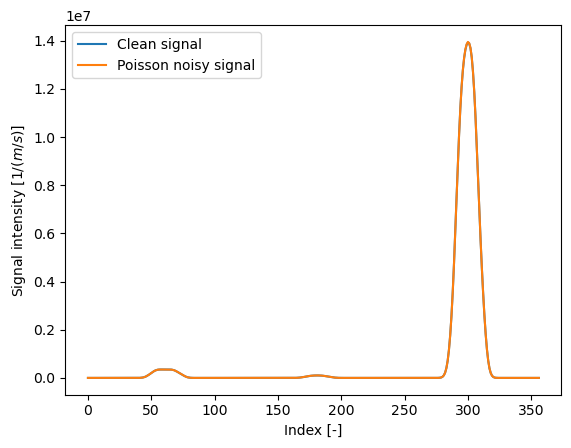

In [11]:
from cuqi.geometry import Image2D

WPsi = cuqi.model.LinearModel(A)
WPsi.domain_geometry = cuqi.geometry.Discrete(WPsi.domain_dim)
WPsi.range_geometry = cuqi.geometry.Discrete(WPsi.range_dim)
y_obs = cuqi.array.CUQIarray(data, geometry=cuqi.geometry.Discrete(WPsi.range_dim))
true_sol = cuqi.array.CUQIarray(true_sol, geometry=WPsi.domain_geometry)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(A@true_sol)
plt.plot(y_obs)
plt.xlabel('Index [-]')
plt.ylabel('Signal intensity $[1/(m/s)]$')
plt.legend(['Clean signal','Poisson noisy signal'])

## Prepare inverse problem
For physical reasons, as explained in the introduction, we expect the first 10 slowing-down coefficients to lie on a smooth curve. Then we expect the next 10 to also lie on a smooth curve, different from the first 10 though. At last, we expect the last 10 coefficients to lie on a third smooth curve. That is why we defined MyDistribution in the beginning. We thus have three sets of 10 coefficients which we imagine lie on three smooth curves. Three decoupled prior distributions are therefore used. This incorporates more physical prior information into the problem by imposing that the slowing-down coefficients does not fluctuate wildly. We regularise the polynomial coefficients with a standard first-order Tikhonov regularisation, modelled by Gaussian Markov Random Fields of order 1 with Neumann boundary conditions. The inverse problem then reads
$$
    \mathbf{c}_{\Lambda}=\min_{\mathbf{c}}\left(||\hat{\mathbf{s}}-\hat{W}\Psi\mathbf{c}||_{2}^{2}+||\Lambda L_{1}\mathbf{c}||_{2}^{2}\right),
$$
where $\Lambda$ allows for different regularisation parameters on each set of 10 coefficients. The "hat" notation on $\hat{\mathbf{s}}$ and $\hat{W}$ refer to them being weighted by the data covariance matrix, which we define below. This is included in the likelihood, which goes into the posterior distribution function.

In [12]:
# Poisson noise
noiselevel = np.array([np.sqrt(data)])                                     # Assume Poisson noise, which is actually correct.
noise_floor = np.array([(1e-3)*np.sqrt(np.max(data))*np.ones(data.shape)]) # Make noise floor to avoid singularities when inverting
nn = np.concatenate((noiselevel, noise_floor), axis=0)
noise = np.diag(np.max(nn, axis=0))                                        # Make diagonal covariance matrix, i.e. uncorrelated noise

Now we are ready to create the Bayesian problem and perform uncertainty quantification analysis. Then we plot the results.

Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Warning (GMRF): Periodic and Neumann boundary conditions are experimental. Sampling using LinearRTO may not produce fully accurate results.
Sample 10000 / 10000


Text(0, 0.5, 'Number of particles [-]')

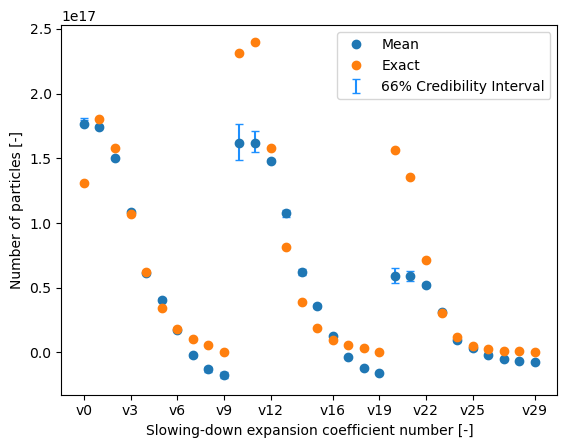

In [13]:
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF

# Gaussian Markov Random Field (boils down to first-order Tikhonov)
# Create a distribution that is a combination of three GMRFs with Neumann boundary conditions.
c1 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
c2 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
c3 = GMRF(np.zeros(10), 1e-30, bc_type='neumann', order=1)
x = MyDistribution([c1, c2, c3])
y = Gaussian(mean=WPsi@x, cov=noise**2)

# Create the joint distribution
joint = JointDistribution(y, x)
# Create the posterior
posterior = joint(y=y_obs)

from cuqi.sampler import LinearRTO

# If using GMRF
# Sample from the posterior using the linear RTO sampler for GMRF
sampler = LinearRTO(posterior)
posterior_samples = sampler.sample(10000)

# Plot the confidence intervals
plt.figure()
posterior_samples.plot_ci(exact=true_sol, percent=66)
plt.xlabel('Slowing-down expansion coefficient number [-]')
plt.ylabel('Number of particles [-]')

Done! As shown, it is quite hard to get good reconstructions from this problem, but we nevertheless get reconstructions which follow the correct trend of the slowing-down coefficients. In this study, the boundaries are very important as they make up a quite large proportion of the total number of coefficients. The imprint of the Neumann boundary conditions, used in the prior distributions, is evident in the mean of the posterior distribution, as can be seen on the blue markers above.

[1]: 

[2]: B. Madsen $\textit{et al}$, Plasma Phys. Control. Fusion, $\textbf{62}$ 115019 (2020)

[3]: B.S. Schmidt $\textit{et al}$, Nucl. Fusion, $\textbf{63}$ 076016 (2023)

[4]: H. Järleblad $\textit{et al}$, Comput. Phys. Commun., $\textbf{294}$ 108930 (2024)

[5]: Monte Carlo Orbit-following code ASCOT
E. Hirvijoki $\textit{et al}$, Comput. Phys. Commun., $\textbf{185}$ 1310-21 (2014)

[6] J. Varje $\textit{et al}$, 2019 (arXiv:1908.02482)
